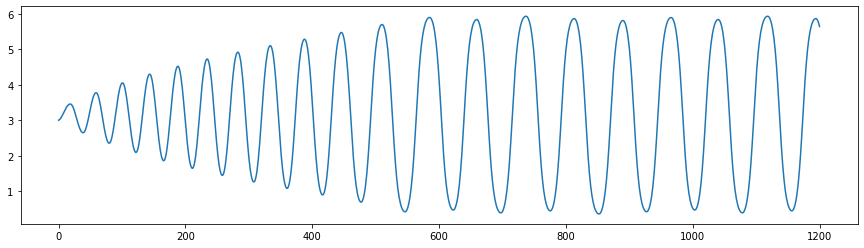

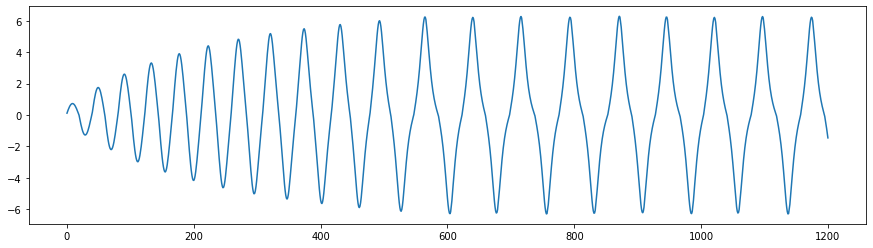

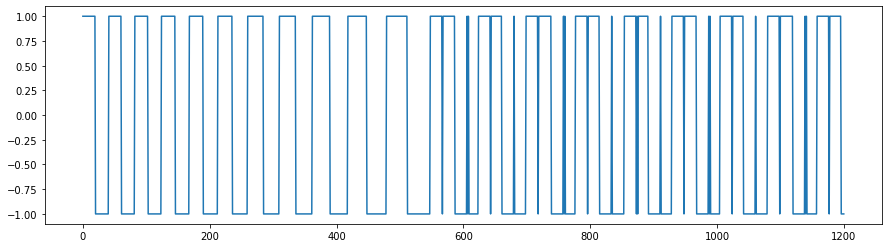

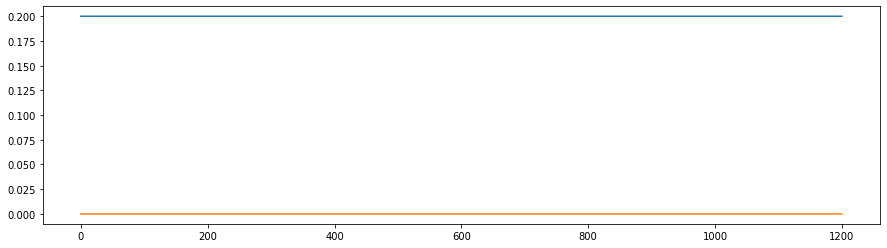

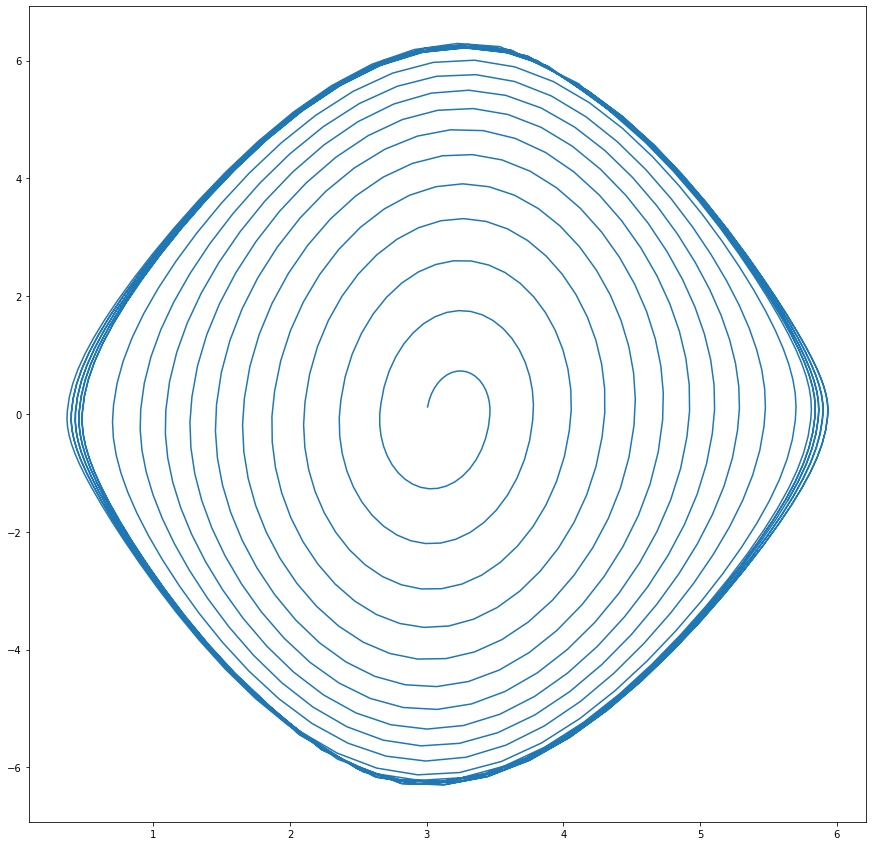

In [20]:
import numpy as np
import cv2
import math
import copy
import matplotlib.pyplot as plt

def plot_1d(data):
    plt.figure(figsize=(15, 4))
    plt.plot(data)
    plt.show()

class Weak_inverted_pendulum:
    def __init__(self, m = 1.0, l = 1.0, g = 10.0, x0 = 3, v0 = 0.0, dt = 0.05,
                 A0 = np.array([[0, 1],
                                [0, 0]]),
                 max_tau = 2, F_hat = 0.1, F = 0.04, use_estimate = True):
        self.m = m
        self.l = l
        self.g = g
        self.max_tau = max_tau
        
        self.x = np.array([[x0], [v0]])
        self.dt = dt
        
        #state transition function
        self.A = A0
        self.A[1, 0] = - self.g / self.l
        
        self.F_hat = F_hat
        self.F = F
        
        self.use_estimate = use_estimate
        
        #control -> xdot (matrix B from x_dot = Ax + Bu)
        self.B = np.array([[0], [1.0 / (self.m * self.l**2)]])
        
    def get_state(self):
        return self.x
    
    def sys_dyn(self, u):
        x_dot = np.zeros_like(self.x)
        
        u_effective = np.clip(u, -self.max_tau, self.max_tau)
        
        #x_dot = self.A @ self.x + self.B * u_effective
        x_dot = copy.deepcopy(self.x)
        
        x_dot[1] = self.g / self.l * math.sin(self.x[0]) + \
            u_effective / (self.m *self.l**2) - self.F_hat * self.x[1]
        
        #print(u_effective)
        
        x_dot[0] = self.x[1]
        
        return x_dot
    
    def integrate_sys_dyn(self, sys_dyn):
        self.x[1] += sys_dyn[1] * self.dt
        self.x[0] += self.x[1] * self.dt
    
    def pendulum_energy(self, x, v, m = 1, l = 1, g = 10):
        return m * l**2 * v**2 / 2 + m * g * l * math.cos(x)

    def energy_based_feedback(self, x, max_tau = 2):
        delta_E = self.pendulum_energy(0, 0) - self.pendulum_energy(x[0, 0], x[1, 0])
        u = math.copysign(max_tau, x[1, 0] * delta_E)
        
        if (self.use_estimate == True):
            # YOUR CODE BELOW
            
            
            
            # YOUR CODE ABOVE
        
        u = np.clip(u, -self.max_tau, self.max_tau)

        return u

def draw_pendulum(canvas, x, y, l, alpha, color = (123, 234, 234),
                  inverted = False):
    direction = 1
    
    if (inverted == True):
        direction = -1
    
    endpoint = (int(x - l * np.cos(alpha + direction * np.pi / 2)),
                int(y + l * np.sin(alpha + direction * np.pi / 2)))
    
    cv2.line(canvas, (x, y), endpoint, (123, 234, 234), 5)
    
    cv2.circle(canvas, endpoint, 25, color, -1)

def swing_up_feedback(x, max_tau = 5):
    if (abs(x[0, 0]) < 1):
        u = math.copysign(max_tau, - 5 * x[0, 0] - x[1, 0])

    else:
        u = math.copysign(max_tau / 7, x[1, 0])

    return u

def run_pendulum_episode(iter_num = 1000, visualize = True, use_estimate = False):
    if (visualize == True):
        WIND_X = 700
        WIND_Y = 700
        canvas = np.ones((700, 700, 3), np.uint8) * 70
    
    max_tau = 1
    
    F_hat = 0.2
    
    pendulum = Weak_inverted_pendulum(x0 = 3, max_tau = max_tau, F_hat = F_hat,
                                      F = 0.0, use_estimate = use_estimate)

    i = 0

    x_traj = []
    v_traj = []
    u_traj = []

    F_hat_traj = []
    F_traj = []

    state_hist = []
    
    delay = 10
    
    while(True):
        state = pendulum.get_state()
        
        state_hist.append(state)

        F_hat_traj.append(pendulum.F_hat)
        F_traj.append(pendulum.F)
        
        #control = swing_up_feedback(state, pendulum.max_tau)
        
        state_for_feedback = state
        
        if (len(state_hist) > delay):
            #print("adfae")
            state_for_feedback = state_hist[-delay]
        
        control = pendulum.energy_based_feedback(state_for_feedback, max_tau = max_tau)
        
        x_dot = pendulum.sys_dyn(control)
                
        pendulum.integrate_sys_dyn(x_dot)
        
        x_traj.append(state[0, 0])
        v_traj.append(state[1, 0])
        u_traj.append(control)
        
        i += 1

        if (i > iter_num):
            break

        if (visualize == True):
            canvas = cv2.addWeighted(canvas, 0.93, canvas, 0, 0)

            draw_pendulum(canvas, WIND_X // 2, WIND_Y // 2, 300,
                          state[0], (123, 234, 45), inverted = True)

            cv2.imshow("pendulum", canvas)

            key = cv2.waitKey(10) & 0xFF

            if (key == ord('q')):
                break
    
    if (visualize == True):
        cv2.destroyAllWindows()
        cv2.waitKey(10)
    
    return x_traj, v_traj, u_traj, F_hat_traj, F_traj

def run_and_visualize(visualize, use_estimate):
    x_hist, v_hist, u_hist, F_hat_hist, F_hist = run_pendulum_episode(iter_num = 1200,
        visualize = visualize, use_estimate = use_estimate)

    plot_1d(x_hist)
    plot_1d(v_hist)
    plot_1d(u_hist)

    plt.figure(figsize=(15, 4))
    plt.plot(F_hat_hist)
    plt.plot(F_hist)
    plt.show()

    plt.figure(figsize=(15, 15))
    plt.plot(x_hist, v_hist)
    plt.show()

run_and_visualize(visualize = False, use_estimate = False)

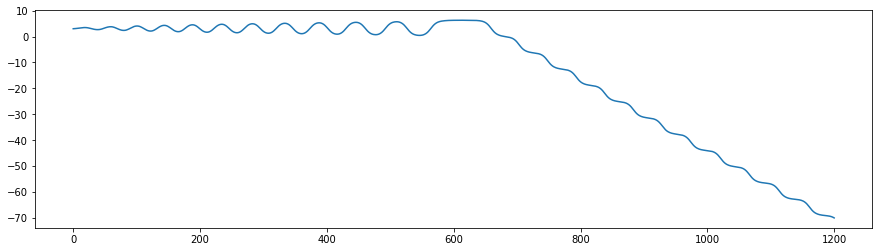

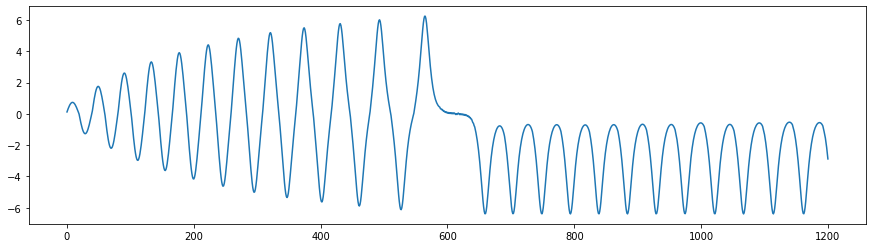

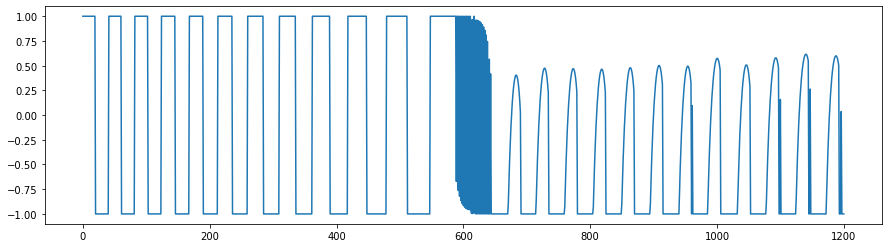

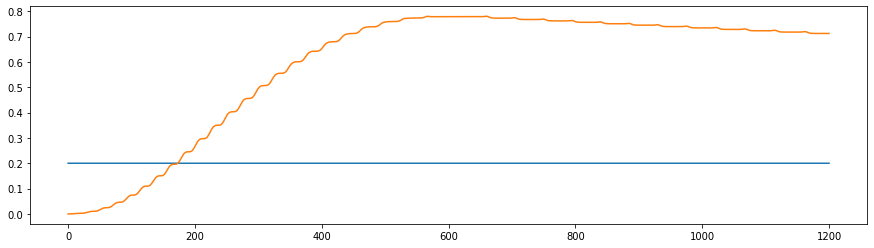

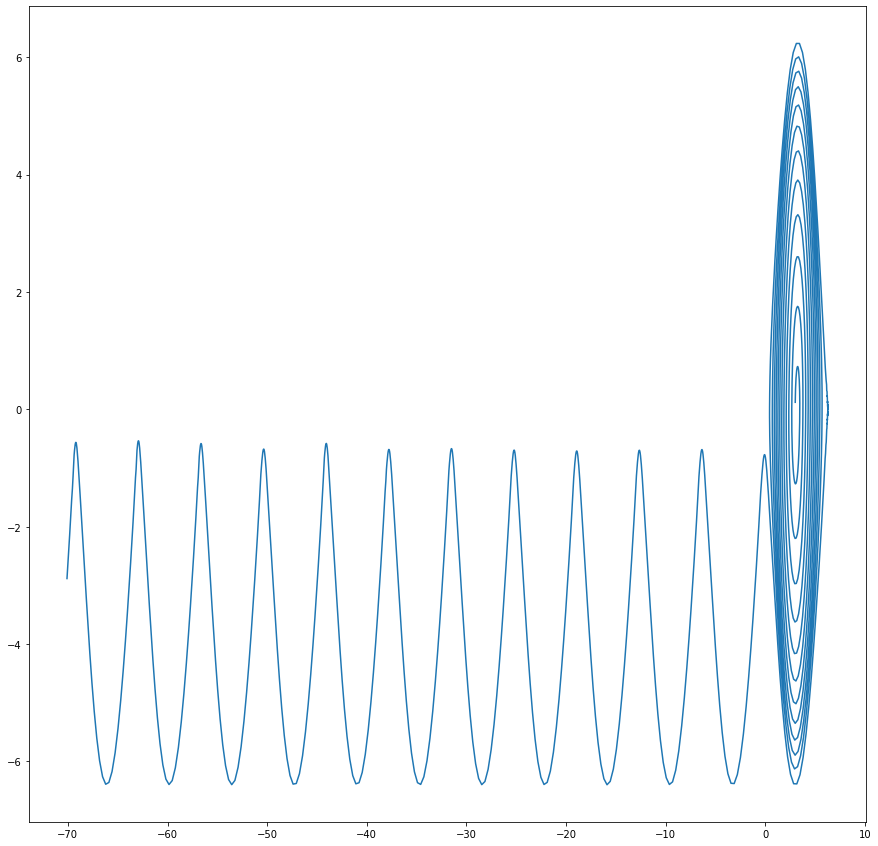

In [21]:
run_and_visualize(visualize = False, use_estimate = True)